## Imports

In [2]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import yfinance as yf
import cplex

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cvxpy as cp

from datetime import datetime, timedelta
from math import sqrt

import os

%matplotlib inline

In [987]:
model = "gpt-4o-2024-11-20" 
# model = "gpt-4.1"
# model = "o4-mini"
# model = "claude-3-7-sonnet-20250219"
# model = "claude-sonnet-4-20250514"
# model = "claude-opus-4-20250514"
# model = "deepseek-chat"
# model = "deepseek-reasoner"
# model = "gemini-2.5-pro-preview-05-06"
# model = "grok-3-latest"
# model = "grok-3-mini-latest"

avg_weights = True

Install CPLEX solver. To setup CPLEX solver for Python:
* Use the script `setup.py` located in the directory `yourCPLEXhome/python`
* Execute the following command from the command line `python yourCPLEXhome/python/setup.py install` or `python yourCPLEXhome/python/setup.py install --home yourPythonPackageshome`
* Set the environment variable `PYTHONPATH` to `yourCPLEXhome/python/VERSION/PLATFORM`

## Identify sector parameters

To process the sector, uncomment the cell. Comment cells with sectors that are not processed at the moment.

In [ ]:
# sector_name = 'energy'
# sector_name_full = 'Energy'
# sector_ticker = '^GSPE'
# full_ticker = 'SP500-10'

In [ ]:
# sector_name = 'materials'
# sector_name_full = 'Materials'
# sector_ticker = '^SP500-15'
# full_ticker = 'SP500-15'

In [ ]:
# sector_name = 'industrials'
# sector_name_full = 'Industrials'
# sector_ticker = '^SP500-20'
# full_ticker = 'SP500-20'

In [ ]:
# sector_name = 'consumer_discretionary'
# sector_name_full = 'Consumer Discretionary'
# sector_ticker = '^SP500-25'
# full_ticker = 'SP500-25'

In [ ]:
# sector_name = 'consumer_staples'
# sector_name_full = 'Consumer Staples'
# sector_ticker = '^SP500-30'
# full_ticker = 'SP500-30'

In [ ]:
# sector_name = 'health_care'
# sector_name_full = 'Health Care'
# sector_ticker = '^SP500-35'
# full_ticker = 'SP500-35'

In [ ]:
# sector_name = 'financials'
# sector_name_full = 'Financials'
# sector_ticker = '^SP500-40'
# full_ticker = 'SP500-40'

In [ ]:
# sector_name = 'information_technology'
# sector_name_full = 'Information Technology'
# sector_ticker = '^SP500-45'
# full_ticker = 'SP500-45'

In [149]:
sector_name = 'communication_services'
sector_name_full = 'Communication Services'
sector_ticker = '^SP500-50'
full_ticker = 'SP500-50'

In [161]:
sector_name = 'utilities'
sector_name_full = 'Utilities'
sector_ticker = '^SP500-55'
full_ticker = 'SP500-55'

In [ ]:
# sector_name = 'real_estate'
# sector_name_full = 'Real Estate'
# sector_ticker = '^SP500-60'
# full_ticker = 'SP500-60'

## Process data

In [162]:
## In-sample end date (using 5 years of weekly data prior to end date)
insample_enddate = datetime(2024, 12, 31)

## Out-of-sample period (1 Apr 2023 to 1 Dec 2023) (using daily data))
outsample_startdate = datetime(2025, 1, 1)
outsample_enddate   = datetime(2025, 6,  15)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Jan 2025

In [163]:
sp500_df = pd.read_csv('SP500.csv')  
companies = sp500_df[sp500_df['GICS Sector'] == sector_name_full]['Symbol']
companies

12      AEE
13      AEP
14      AES
42      ATO
46      AWK
84      CEG
98      CMS
100     CNP
124       D
144     DTE
145     DUK
152      ED
155     EIX
167      ES
170     ETR
171    EVRG
173     EXC
184      FE
285     LNT
332     NEE
335      NI
339     NRG
363     PCG
364     PEG
378     PNW
382     PPL
413      SO
417     SRE
474     VST
484     WEC
496     XEL
Name: Symbol, dtype: object

## Load Data

In [164]:
index_tickers = ["^GSPC", "^IXIC", sector_ticker]

index_data_outs = pd.DataFrame()

# Download historical data for each index for out-of-sample period
for ticker in index_tickers:
    index_df = yf.download(ticker, start=outsample_startdate, end=outsample_enddate, interval='1d', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_outs[ticker] = index_df['Index_Return']

index_data_outs.index = pd.to_datetime(index_data_outs.index)

valid_index_tickers_outs = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in out-of-sample period
    if ticker in index_data_outs.columns and index_data_outs[ticker].notna().all():
        valid_index_tickers_outs.append(ticker)


index_tickers = valid_index_tickers_outs

print("Valid Index Tickers in Out-of-Sample Period")
print(valid_index_tickers_outs)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in Out-of-Sample Period
['^GSPC', '^IXIC', '^SP500-55']


In [165]:
index_data_outs ## for checking, not needed in final code

,^GSPC,^IXIC,^SP500-55
Date,,,
2025-01-03,0.012596,0.017680,0.010986
2025-01-06,0.005538,0.012400,-0.010943
2025-01-07,-0.011104,-0.018893,-0.002914
2025-01-08,0.001560,-0.000554,-0.000103
2025-01-10,-0.015412,-0.016287,-0.005717
...,...,...,...
2025-06-09,0.000920,0.003138,-0.006583
2025-06-10,0.005483,0.006317,0.001890
2025-06-11,-0.002744,-0.005027,0.000441


In [166]:
index_tickers = ["^GSPC", "^IXIC", sector_ticker]

index_data_ins = pd.DataFrame()

# Download historical data for each index for in-sample period
for ticker in index_tickers:
    index_df = yf.download(ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_ins[ticker] = index_df['Index_Return']

index_data_ins.index = pd.to_datetime(index_data_ins.index)

valid_index_tickers_ins = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in in-sample period
    if ticker in index_data_ins.columns and index_data_ins[ticker].notna().all():
        valid_index_tickers_ins.append(ticker)


# index_tickers = valid_index_tickers_ins

print("Valid Index Tickers in In-Sample Period")
print(valid_index_tickers_ins)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in In-Sample Period
['^GSPC', '^IXIC', '^SP500-55']


In [167]:
index_data_ins ## for checking, not needed in final code

,^GSPC,^IXIC,^SP500-55
Date,,,
2020-01-13,0.019682,0.022887,0.037605
2020-01-20,-0.010256,-0.007885,0.024004
2020-01-27,-0.021226,-0.017603,0.008150
2020-02-03,0.031682,0.040386,-0.006256
2020-02-10,0.015762,0.022128,0.024260
...,...,...,...
2024-12-02,0.009597,0.033385,-0.038355
2024-12-09,-0.006433,0.003371,-0.026995
2024-12-16,-0.019871,-0.017771,-0.016233


In [168]:
## In-sample end date (using 10 years of weekly data prior to end date)
insample_enddate = datetime(2024, 12, 31)

## Out-of-sample period (1 Apr 2023 to 1 Dec 2023) (using daily data))
outsample_startdate = datetime(2025, 1, 1)
outsample_enddate   = datetime(2025, 6,  15)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Jan 2025

In [169]:
# in-sample
sp500_ins = yf.download(sector_ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust=False) 
sp500_ins['SP_Return'] = sp500_ins['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_ins.dropna(subset=[('SP_Return','')], inplace=True) # 1256 X 7 (removed first row with NaN in return)

# out-of-sample
sp500_outs = yf.download(sector_ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust=False) 
sp500_outs['SP_Return'] = sp500_outs['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_outs.dropna(subset=[('SP_Return','')], inplace=True) # removed first row with NaN in return 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

In [170]:
insample_data_filename = f'4_returns_insample/SP500_{sector_name}_returns_till_Jan2025.csv'
outsample_data_filename = f'4_returns_outsample/SP500_{sector_name}_returns_since_Jan2025.csv'

In [171]:
print("Reading data from file", insample_data_filename)
df_returns = pd.read_csv(insample_data_filename, index_col=0)

print("Reading data from file", outsample_data_filename)
df_returnsOUT = pd.read_csv(outsample_data_filename, index_col=0)

Reading data from file 4_returns_insample/SP500_utilities_returns_till_Jan2025.csv
Reading data from file 4_returns_outsample/SP500_utilities_returns_since_Jan2025.csv


## TEST: mean cumulative out-of-sample return for each sector

In [ ]:
temp_index_data_outs = index_data_outs.copy()
outsample_data = pd.DataFrame(index=temp_index_data_outs.index)
outsample_data[sector_name_full] = (1 + temp_index_data_outs[ticker]).cumprod()
outsample_data.index = pd.to_datetime(outsample_data.index)
outsample_data
print(f"mean cul. return of outdata: {outsample_data.mean()}")
print(f"volatility: {outsample_data.std()} ")

mean cul. return of outdata: Utilities    1.030009
dtype: float64
volatility: Utilities    0.02404
dtype: float64 


Utilities    114.331024
dtype: float64

## Processing

In [1009]:
def process_sector_data(df_sector):
    stocks = list(df_sector['Stock'].str.replace(" ", "").values)
    eq_weights = [1/len(stocks)] * len(stocks)
    llm_weights = list(df_sector['Weight'].values.astype(float))

    return stocks, eq_weights, llm_weights

In [1010]:
# not avg_weights
#gpt
if model == 'gpt-4o-2024-11-20' and not avg_weights:
    csv_filename = f'cached/gpt/4o_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'gpt-4.1' and not avg_weights:
    csv_filename = f'cached/gpt/4.1_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'o4-mini' and not avg_weights:
    csv_filename = f'cached/gpt/o4-mini_weights_assigned/responses15_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat' and not avg_weights:
    csv_filename = f'cached/ds/dsV3_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner' and not avg_weights:
    csv_filename = f'cached/ds/dsR1_weights_assigned/responses15_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219' and not avg_weights:
    csv_filename = f'cached/claude/sonnet-3.7_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514' and not avg_weights:
    csv_filename = f'cached/claude/sonnet-4_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514' and not avg_weights:
    csv_filename = f'cached/claude/opus-4_weights_assigned/responses15_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and not avg_weights:
    csv_filename = f'cached/gemini/gemini_weights_assigned/responses15_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest' and not avg_weights:
    csv_filename = f'cached/grok/grok3_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest' and not avg_weights:
    csv_filename = f'cached/grok/grok3-mini_weights_assigned/responses15_auto_{sector_name}.csv'

# average weights
# gpt
elif model == 'gpt-4o-2024-11-20' and avg_weights:
    csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'gpt-4.1' and avg_weights:
    csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'o4-mini' and avg_weights:
    csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat' and avg_weights:
    csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner' and avg_weights:
    csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
    csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514' and avg_weights:
    csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514' and avg_weights:
    csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
    csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest' and avg_weights:
    csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest' and avg_weights:
    csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'

In [1011]:
model_name_mapping = {
    "gpt-4o-2024-11-20": "gpt4o",
    "gpt-4.1": "gpt4.1", 
    "o4-mini": "o4-mini",
    "claude-3-7-sonnet-20250219": "sonnet-3.7",
    "claude-sonnet-4-20250514": "sonnet-4",
    "claude-opus-4-20250514": "opus-4",
    "deepseek-chat": "dsV3",
    "deepseek-reasoner": "dsR1",
    "gemini-2.5-pro-preview-05-06": "gemini",
    "grok-3-latest": "grok3",
    "grok-3-mini-latest": "grok3-mini"
}

In [1012]:
model_short = model_name_mapping[model]

In [1013]:
df_sector = pd.read_csv(csv_filename)

stocks, eq_weights, llm_weights = process_sector_data(df_sector)

# Assign variables dynamically
globals()[f'{model_short}_df_{sector_name}'] = df_sector
globals()[f'{model_short}_stocks_{sector_name}'] = stocks
globals()[f'{model_short}_eq_weights_{sector_name}'] = eq_weights
globals()[f'{model_short}_weights_llm_{sector_name}'] = llm_weights

In [1014]:
globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [1015]:
df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']] ## for checking, not needed in final code

,AMT,PLD,EQIX,PSA,O,DLR,SPG,AVB,WELL,VICI,EXR,ARE,MAA,CPT,EQR
Date,,,,,,,,,,,,,,,
2025-01-03,0.008452,0.013140,0.016670,0.013049,0.012928,0.026780,0.014637,0.009674,0.008820,0.016212,0.021991,0.017026,0.016987,0.020841,0.011845
2025-01-06,-0.012599,0.009751,-0.020803,-0.015377,-0.010323,-0.011775,-0.009428,-0.029155,-0.014068,0.003394,-0.016420,-0.014421,-0.034116,-0.030836,-0.035402
2025-01-07,-0.017142,-0.000750,0.000074,0.008011,-0.004172,0.001559,-0.001376,-0.007284,0.001532,-0.010487,-0.000875,-0.003786,-0.010082,-0.027763,-0.013745
2025-01-08,0.011402,-0.010133,0.011669,-0.009189,0.000000,0.005504,0.002986,0.005397,0.018030,-0.014359,-0.002830,0.000308,0.007285,0.006618,0.001038
2025-01-10,-0.031977,-0.018104,-0.053846,-0.021898,-0.015997,-0.041632,-0.021352,-0.007534,-0.013441,-0.021505,-0.008243,-0.024643,-0.007700,-0.016931,-0.007998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,0.001365,0.001287,-0.007600,-0.001089,0.014464,-0.000905,0.002625,0.018558,-0.026805,0.017477,0.004071,0.017298,0.007405,0.014763,0.011971
2025-06-10,0.008363,0.005141,-0.000154,0.004759,0.009505,0.005717,0.002930,0.005074,0.003925,0.013429,0.007844,0.022021,0.005695,0.004849,0.009810
2025-06-11,-0.001165,-0.009042,-0.015033,-0.012697,0.007149,-0.010411,-0.007396,-0.006876,-0.004374,0.000925,-0.008904,-0.001909,-0.009878,-0.005842,-0.010429


In [1016]:
tickers_sp500out = np.array(df_returnsOUT.columns)

## Efficient frontiers

In [1017]:
def frontiers(returns_df, asset_list, num_portf, lb, ub, risk_free_rate, model_name):
    # Calculate the covariance matrix and expected returns and scaling them to ANNUAL
    # ts_freq = np.diff(returns_df.index).min()
    try:
        ts_freq = pd.infer_freq(returns_df.index)[0]

        scalef = 252
        if ts_freq=='W':
            scalef = 52
        elif ts_freq=='M':
            scalef = 12
    except TypeError:        
        scalef = 52
        
    Q = returns_df[asset_list].cov() * scalef  # 52 weeks in a year
    mu_pd = returns_df[asset_list].mean() * scalef
    mu = mu_pd.values
    
    ## Minimum variance portfolio
    w = cp.Variable(len(asset_list))
    prob1 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                      [sum(w) == 1,
                       w >= 0])
    prob1.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_minVar = w.value
    # var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
    ret_minVar = np.dot(mu, w_minVar)
    
    ## Max return portfolio
    w = cp.Variable(len(asset_list))
    prob2 = cp.Problem(cp.Maximize(mu.T@w),
                    [sum(w) == 1,
                     w >= 0])
    prob2.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_maxRet = w.value
    # var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet))
    ret_maxRet = np.dot(mu, w_maxRet)
    
    ## Efficient Frontier
    targetRet = np.linspace(ret_minVar, ret_maxRet, num_portf)
    w = cp.Variable(len(asset_list))
    eps = cp.Parameter()
    eps.value = targetRet[0]
    prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                    [mu.T@w >= eps,
                     sum(w) == 1,
                     w >= 0])
    # Compute efficient frontier
    w_front = []
    var_front = []
    ret_front = []
    sharpe_ratio_front = []
    
    for epsilon in targetRet:
        eps.value = epsilon
        prob3.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
        w_front.append(w.value)
        var_front.append(np.dot(w.value, np.dot(Q, w.value)))
        ret_front.append(np.dot(mu, w.value))
        sharpe_ratio = (np.dot(mu, w.value) - risk_free_rate) / np.sqrt(np.dot(w.value, np.dot(Q, w.value)))
        sharpe_ratio_front.append(sharpe_ratio)
    
    # Find the portfolio with the maximum Sharpe ratio
    max_sharpe_ratio_index = np.argmax(sharpe_ratio_front)
    # weights_max_sharpe = w_front[max_sharpe_ratio_index]
    ret_max_sharpe = ret_front[max_sharpe_ratio_index]
    var_max_sharpe = var_front[max_sharpe_ratio_index]
        
    ## Minimum variance portfolio with bounds
    w = cp.Variable(len(asset_list))
    prob5 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                    [cp.sum(w) == 1,
                     w >= lb,
                     w <= ub])
    prob5.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_minVar_bounded = w.value
    # var_minVar_bounded = np.dot(w_minVar_bounded, np.dot(Q, w_minVar_bounded))
    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_minvar_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in w_minVar_bounded]))

    ret_minVar_bounded = np.dot(mu, w_minVar_bounded)
    
    ## Max return portfolio with bounds
    w = cp.Variable(len(asset_list))
    prob6 = cp.Problem(cp.Maximize(mu.T@w),
                        [cp.sum(w) == 1,
                         w >= lb,
                         w <= ub])
    prob6.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_maxRet_bounded = w.value
    # var_maxRet_bounded = np.dot(w_maxRet_bounded, np.dot(Q, w_maxRet_bounded))
    ret_maxRet_bounded = np.dot(mu, w_maxRet_bounded)

    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_maxret_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in w_maxRet_bounded]))
    # ret_maxRet_bounded = np.dot(mu, w_maxRet_bounded)    

    ## Efficient Frontier with bounds
    targetRetB = np.linspace(ret_minVar_bounded, ret_maxRet_bounded, num_portf)
    w = cp.Variable(len(asset_list))
    eps = cp.Parameter()
    eps.value = targetRetB[0]
    prob7 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                        [mu.T @ w >= eps,
                         cp.sum(w) == 1,
                         w >= lb,
                         w <= ub])
    w_front_bounded = []
    var_front_bounded = []
    ret_front_bounded = []
    sharpe_ratio_front_bounded = []
    
    for epsilon in targetRetB:
        eps.value = epsilon
        prob7.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
        w_front_bounded.append(w.value)
        var_front_bounded.append(np.dot(w.value, np.dot(Q, w.value)))

        ret_front_bounded.append(np.dot(mu, w.value))
        
        sharpe_ratio = (np.dot(mu, w.value) - risk_free_rate) / np.sqrt(np.dot(w.value, np.dot(Q, w.value)))
        sharpe_ratio_front_bounded.append(sharpe_ratio)
        
    # Find the portfolio with the maximum Sharpe ratio
    max_sharpe_ratio_bounded_index = np.argmax(sharpe_ratio_front_bounded)
    weights_max_sharpe_bounded = w_front_bounded[max_sharpe_ratio_bounded_index]
    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_maxsharpe_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in weights_max_sharpe_bounded]))
    ret_max_sharpe_bounded = ret_front_bounded[max_sharpe_ratio_bounded_index]
    var_max_sharpe_bounded = var_front_bounded[max_sharpe_ratio_bounded_index]

    return (ret_front, var_front, ret_max_sharpe, var_max_sharpe, \
            ret_front_bounded, var_front_bounded, ret_max_sharpe_bounded, \
                var_max_sharpe_bounded, w_minVar_bounded, w_maxRet_bounded, weights_max_sharpe_bounded)

In [1018]:
lbA = 0.03
ubA = 0.13

In [1019]:
df_returns = pd.read_csv(f'4_returns_insample/SP500_{sector_name}_returns_till_Jan2025.csv')
try:
    df_returns['Date'] = pd.to_datetime(df_returns['Date'], format='%Y-%m-%d %H:%M:%S')
except ValueError:
    df_returns['Date'] = pd.to_datetime(df_returns['Date'] + ' 00:00:00', format='%Y-%m-%d %H:%M:%S')

df_returns = df_returns.set_index('Date')

In [1020]:
# ret_front15, var_front15, ret_max_sharpe15, var_max_sharpe15, ret_front_bounded15, \
#     var_front_bounded15, ret_max_sharpe_bounded15, var_max_sharpe_bounded15, w_min_var_bounded15, \
#     w_max_ret_bounded15, w_max_sharpe_bounded15 = frontiers(df_returns, globals()[f'stocks_{sector_name}'], 200, lbA, ubA, 0.01, model)

In [1021]:
ret_front15, var_front15, ret_max_sharpe15, var_max_sharpe15, ret_front_bounded15, \
    var_front_bounded15, ret_max_sharpe_bounded15, var_max_sharpe_bounded15, w_min_var_bounded15, \
    w_max_ret_bounded15, w_max_sharpe_bounded15 = frontiers(df_returns, globals()[f'{model_short}_stocks_{sector_name}'], 200, lbA, ubA, 0.01, model_short)

globals()[f'{model_short}_ret_front15_{sector_name}'] = ret_front15
globals()[f'{model_short}_var_front15_{sector_name}'] = var_front15
globals()[f'{model_short}_ret_max_sharpe15_{sector_name}'] = ret_max_sharpe15
globals()[f'{model_short}_var_max_sharpe15_{sector_name}'] = var_max_sharpe15
globals()[f'{model_short}_ret_front_bounded15_{sector_name}'] = ret_front_bounded15
globals()[f'{model_short}_var_front_bounded15_{sector_name}'] = var_front_bounded15
globals()[f'{model_short}_ret_max_sharpe_bounded15_{sector_name}'] = ret_max_sharpe_bounded15
globals()[f'{model_short}_var_max_sharpe_bounded15_{sector_name}'] = var_max_sharpe_bounded15
globals()[f'{model_short}_w_min_var_bounded15_{sector_name}'] = w_min_var_bounded15
globals()[f'{model_short}_w_max_ret_bounded15_{sector_name}'] = w_max_ret_bounded15
globals()[f'{model_short}_w_max_sharpe_bounded15_{sector_name}'] = w_max_sharpe_bounded15

## Plot frontiers

In [1022]:
def plot_frontiers(returns_df, params_llm, sector, model):
    asset_list, weights_eq, weights_llm, ret_front, var_front, ret_max_sharpe, \
        var_max_sharpe, ret_front_bounded, var_front_bounded, ret_max_sharpe_bounded, \
            var_max_sharpe_bounded = params_llm
    
    # Calculate the covariance matrix and expected returns and scaling them to ANNUAL
    try:
        ts_freq = pd.infer_freq(returns_df.index)[0]
        ##print(ts_freq) ##

        scalef = 252
        if ts_freq=='W':
            scalef = 52
        elif ts_freq=='M':
            scalef = 12
    except TypeError:        
        scalef = 252 ##
    ##print (scalef)##

    Q = returns_df[asset_list].cov() * scalef  # 52 weeks in a year
    mu_pd = returns_df[asset_list].mean() * scalef
    mu = mu_pd.values
     
    # Compute expected returns, variances, and standard deviations for LLM weighted portfolio
    ret_llm = np.dot(mu, weights_llm)
    var_llm = np.dot(weights_llm, np.dot(Q, weights_llm))
    std_llm = np.sqrt(var_llm)

    # Compute expected returns, variances, and standard deviations for equally weighted portfolio
    ret_eq = np.dot(mu, weights_eq)
    var_eq = np.dot(weights_eq, np.dot(Q, weights_eq))
    std_eq = np.sqrt(var_eq)

    fig = plt.figure(figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
    ax = plt.gca()
    plt.rcParams['figure.figsize'] = [10, 5]

    ax.scatter(x=np.sqrt(var_front[0]), y=ret_front[0], marker='D', s=50, color='DarkGreen', label='minimum variance portfolio')
    ax.scatter(x=np.sqrt(var_front[-1]), y=ret_front[-1], marker='s', s=50, color='DarkMagenta', label='maximum return portfolio')
    ax.scatter(x=np.sqrt(var_front_bounded[0]), y=ret_front_bounded[0], marker='D', s=50, color='pink', label='minimum variance portfolio bounded')
    ax.scatter(x=np.sqrt(var_front_bounded[-1]), y=ret_front_bounded[-1], marker='s', s=50, color='brown', label='maximum return portfolio bounded')

    ax.plot(np.sqrt(var_front), ret_front, 'k--', label='efficient frontier')

    # Plot efficient frontier for bounded case
    ax.plot(np.sqrt(var_front_bounded), ret_front_bounded, 'k-', label='efficient frontier bounded')

    # Plot volatility versus expected return for individual stocks
    ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, color='lightgrey', label='individual stocks')

    ax.scatter(x=std_llm, y=ret_llm, marker='o', s=50, color='red', label='LLM weighted LLM portfolio')

    ax.scatter(x=std_eq, y=ret_eq, marker='o', s=50, color='yellow', label='Equally weighted LLM portfolio')

    ax.scatter(x=np.sqrt(var_max_sharpe), y=ret_max_sharpe, marker='o', s=50, color='green', label='Maximum Sharpe portfolio')

    ax.scatter(x=np.sqrt(var_max_sharpe_bounded), y=ret_max_sharpe_bounded, marker='o', s=50, color='cyan', label='Maximum Sharpe portfolio bounded')

    # Format and display the final plot
    ax.axis([0.9 * np.sqrt(var_front[0]), 1.2 * np.max(np.sqrt(np.diag(Q))), np.min(mu) - 0.1 * (np.max(mu) - np.min(mu)), 1.1 * ret_front[-1]])
    ax.set_xlabel('Volatility (Standard Deviation)')
    ax.set_ylabel('Expected Return (annualized)')
    plt.title(f'Efficient frontier for {str(len(asset_list))} stocks selected by {model} for {sector}')
    ax.legend(loc="lower right", fontsize='small')  # Adjust font size here
    ax.grid()
    plt.show()

In [1023]:
# params_llm = [globals()[f'stocks_{sector_name}'], globals()[f'eq_weights_{sector_name}'], globals()[f'weights_llm_{sector_name}'], \
#                ret_front15, var_front15, ret_max_sharpe15, var_max_sharpe15, ret_front_bounded15, var_front_bounded15, ret_max_sharpe_bounded15,\
#                   var_max_sharpe_bounded15]


In [1024]:
params_llm = [globals()[f'{model_short}_stocks_{sector_name}'], globals()[f'{model_short}_eq_weights_{sector_name}'], globals()[f'{model_short}_weights_llm_{sector_name}'], \
               globals()[f'{model_short}_ret_front15_{sector_name}'], globals()[f'{model_short}_var_front15_{sector_name}'], globals()[f'{model_short}_ret_max_sharpe15_{sector_name}'], globals()[f'{model_short}_var_max_sharpe15_{sector_name}'], \
               globals()[f'{model_short}_ret_front_bounded15_{sector_name}'], globals()[f'{model_short}_var_front_bounded15_{sector_name}'], globals()[f'{model_short}_ret_max_sharpe_bounded15_{sector_name}'], \
               globals()[f'{model_short}_var_max_sharpe_bounded15_{sector_name}']]


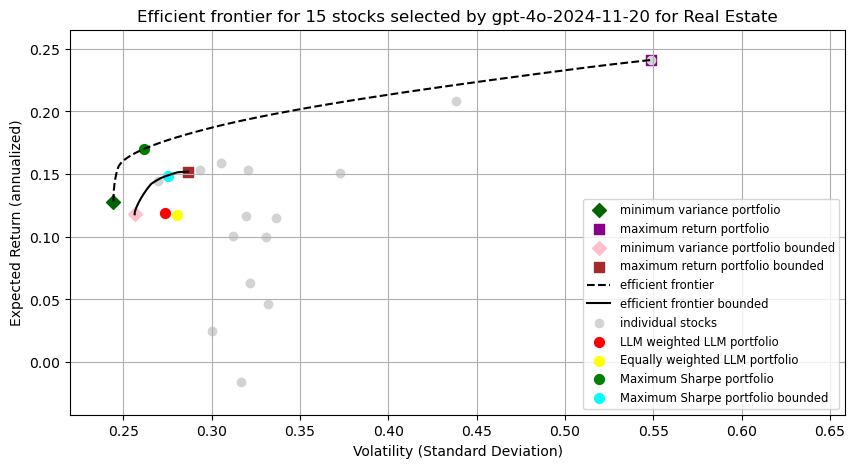

In [1025]:
## I think this is for in-sample data?
plot_frontiers(df_returns, params_llm, sector_name_full, model)

## Plot portfolio performance

In [1026]:
# Weights of all portfolios
weights = {
    f"LLM_weighted_{sector_name}": globals()[f'{model_short}_weights_llm_{sector_name}'],
    f"LLM_equal_{sector_name}": globals()[f'{model_short}_eq_weights_{sector_name}'],
    "LLM Min Var": globals()[f'{model_short}_w_min_var_bounded15_{sector_name}'],
    "LLM Max Ret": globals()[f'{model_short}_w_max_ret_bounded15_{sector_name}'],
    "LLM Max Sharpe": globals()[f'{model_short}_w_max_sharpe_bounded15_{sector_name}']
}

In [1027]:
temp_stock_return = globals()[f'{model_short}_stock_returns_{sector_name}']
temp_stock_return.index = pd.to_datetime(temp_stock_return.index)
first_date = temp_stock_return.index[0]
previous_trading_date = first_date - BDay(1)
full_index = [previous_trading_date] + list(temp_stock_return.index)
cumulative_returns_llm = pd.DataFrame(index=full_index) ## 创建df 只有index-日期 这一列 ## modified 

In [1028]:
i = 0
for name, weight in weights.items():
    temp_stock_return = globals()[f'{model_short}_stock_returns_{sector_name}']
    first_date = temp_stock_return.index[0]
    temp_stock_return.index = pd.to_datetime(temp_stock_return.index)
    previous_trading_date = first_date - BDay(1)
    baseline_row = pd.DataFrame(
        data=np.zeros((1, temp_stock_return.shape[1])),  
        index=[previous_trading_date],                    
        columns=temp_stock_return.columns               
    )
    temp_stock_return_with_baseline = pd.concat([baseline_row, temp_stock_return])
    portfolio_return = (temp_stock_return_with_baseline * weight).sum(axis=1)
    cumulative_returns_llm[name] = (1 + portfolio_return).cumprod()
    i+=1

In [1029]:
cumulative_returns_llm

,LLM_weighted_real_estate,LLM_equal_real_estate,LLM Min Var,LLM Max Ret,LLM Max Sharpe
2025-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
2025-01-03,1.014488,1.015270,1.015982,1.016572,1.016161
2025-01-06,1.002124,0.998919,0.998665,1.002008,1.000514
2025-01-07,0.998042,0.993173,0.994335,0.998980,0.998874
2025-01-08,1.000324,0.995406,0.997105,1.002806,1.002487
...,...,...,...,...,...
2025-06-09,1.050207,1.028980,1.038032,1.038224,1.036014
2025-06-10,1.056745,1.036451,1.044722,1.044416,1.041720
2025-06-11,1.049885,1.029825,1.036108,1.036644,1.033019
2025-06-12,1.054555,1.034824,1.041573,1.040533,1.036659


In [1030]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_llm[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_llm.index = pd.to_datetime(cumulative_returns_llm.index)
outsample_data = cumulative_returns_llm.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()


for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))
    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))


num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of {num_asset} Asset Portfolios ({model}, equal weight) and {full_ticker} ({sector_name_full}) from Jan 1 to Jun 15',
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified"
)

fig.show()

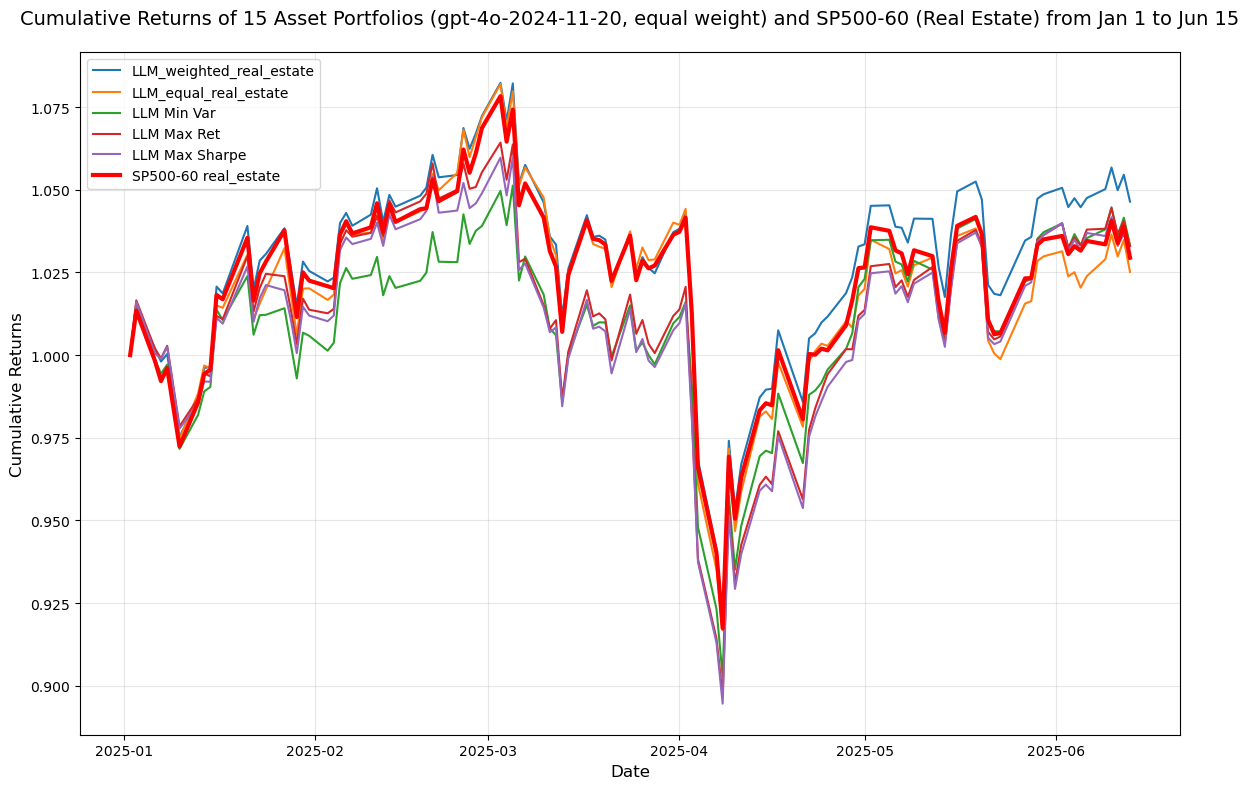

In [1031]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_llm[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_llm.index = pd.to_datetime(cumulative_returns_llm.index)
outsample_data = cumulative_returns_llm.loc[outsample_startdate:outsample_enddate]

fig, ax = plt.subplots(figsize=(12, 8))

for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        ax.plot(outsample_data.index, 
                outsample_data[column], 
                linewidth=3, 
                color='red', 
                label=column)
    else:
        ax.plot(outsample_data.index, 
                outsample_data[column], 
                label=column)

num_asset = len(df_sector)
ax.set_title(f'Cumulative Returns of {num_asset} Asset Portfolios ({model}, equal weight) and {full_ticker} ({sector_name_full}) from Jan 1 to Jun 15', 
             fontsize=14, pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Returns', fontsize=12)


ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
# fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Comparing LLM Models: OpenAI, Anthropic, DeepSeek, Google, and X.AI

In [1032]:
for model, model_short in model_name_mapping.items():
    if model == 'gpt-4o-2024-11-20' and avg_weights:
        csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'gpt-4.1' and avg_weights:
        csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'o4-mini' and avg_weights:
        csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    # ds
    elif model == 'deepseek-chat' and avg_weights:
        csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner' and avg_weights:
        csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    # claude
    elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
        csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'claude-sonnet-4-20250514' and avg_weights:
        csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'claude-opus-4-20250514' and avg_weights:
        csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    # gemini
    elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
        csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    # grok
    elif model == 'grok-3-latest' and avg_weights:
        csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest' and avg_weights:
        csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    
    df_sector = pd.read_csv(csv_filename)

    stocks, eq_weights, llm_weights = process_sector_data(df_sector)

    # Assign variables dynamically
    globals()[f'{model_short}_df_{sector_name}'] = df_sector
    globals()[f'{model_short}_stocks_{sector_name}'] = stocks
    globals()[f'{model_short}_eq_weights_{sector_name}'] = eq_weights
    globals()[f'{model_short}_weights_llm_{sector_name}'] = llm_weights

In [1033]:
for model, model_short in model_name_mapping.items():
    globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [1034]:
for model, model_short in model_name_mapping.items():
    ret_front15, var_front15, ret_max_sharpe15, var_max_sharpe15, ret_front_bounded15, \
        var_front_bounded15, ret_max_sharpe_bounded15, var_max_sharpe_bounded15, w_min_var_bounded15, \
        w_max_ret_bounded15, w_max_sharpe_bounded15 = frontiers(df_returns, globals()[f'{model_short}_stocks_{sector_name}'], 200, lbA, ubA, 0.01, model_short)

    globals()[f'{model_short}_ret_front15_{sector_name}'] = ret_front15
    globals()[f'{model_short}_var_front15_{sector_name}'] = var_front15
    globals()[f'{model_short}_ret_max_sharpe15_{sector_name}'] = ret_max_sharpe15
    globals()[f'{model_short}_var_max_sharpe15_{sector_name}'] = var_max_sharpe15
    globals()[f'{model_short}_ret_front_bounded15_{sector_name}'] = ret_front_bounded15
    globals()[f'{model_short}_var_front_bounded15_{sector_name}'] = var_front_bounded15
    globals()[f'{model_short}_ret_max_sharpe_bounded15_{sector_name}'] = ret_max_sharpe_bounded15
    globals()[f'{model_short}_var_max_sharpe_bounded15_{sector_name}'] = var_max_sharpe_bounded15
    globals()[f'{model_short}_w_min_var_bounded15_{sector_name}'] = w_min_var_bounded15
    globals()[f'{model_short}_w_max_ret_bounded15_{sector_name}'] = w_max_ret_bounded15
    globals()[f'{model_short}_w_max_sharpe_bounded15_{sector_name}'] = w_max_sharpe_bounded15

In [1035]:
temp_stock_return_compare = globals()[f'{model_short}_stock_returns_{sector_name}']

temp_stock_return_compare.index = pd.to_datetime(temp_stock_return_compare.index)
first_date_compare = temp_stock_return_compare.index[0]
previous_trading_date_compare = first_date_compare - BDay(1)
full_index_compare = [previous_trading_date_compare] + list(temp_stock_return_compare.index)

cumulative_returns_compare = pd.DataFrame(index=full_index_compare)

In [1036]:
globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [1037]:
for model_name, model_short in model_name_mapping.items():
    dict_name = f"weights_{model_short}"

    weights_dict = {
        f"{model_short}_weighted_{sector_name}": globals()[f'{model_short}_weights_llm_{sector_name}'],
        f"{model_short}_equal_{sector_name}": globals()[f'{model_short}_eq_weights_{sector_name}'],
        f"{model_short} Min Var": globals()[f'{model_short}_w_min_var_bounded15_{sector_name}'],
        f"{model_short} Max Ret": globals()[f'{model_short}_w_max_ret_bounded15_{sector_name}'],
        f"{model_short} Max Sharpe": globals()[f'{model_short}_w_max_sharpe_bounded15_{sector_name}']
    }
    
    globals()[dict_name] = weights_dict

In [1038]:
model_shorts = ["gpt4o", "gpt4.1", "o4-mini", "sonnet-3.7", "sonnet-4", "opus-4", 
                "dsV3", "dsR1", "gemini", "grok3", "grok3-mini"]

for model_short in model_shorts:
    weights_dict = globals()[f'weights_{model_short}']
    
    temp_stock_return_compare = globals()[f'{model_short}_stock_returns_{sector_name}']

    for name, weight in weights_dict.items():
        temp_stock_return_compare.index = pd.to_datetime(temp_stock_return_compare.index)
        first_date_compare = temp_stock_return_compare.index[0]
        previous_trading_date_compare = first_date_compare - BDay(1)
        baseline_row1 = pd.DataFrame(
            data=np.zeros((1, temp_stock_return_compare.shape[1])),  
            index=[previous_trading_date_compare],                    
            columns=temp_stock_return_compare.columns               
        )
        temp_stock_return_compare_with_baseline = pd.concat([baseline_row1, temp_stock_return_compare])

        portfolio_return_compare = (temp_stock_return_compare_with_baseline * weight).sum(axis=1)
        cumulative_returns_compare[name] = (1 + portfolio_return_compare).cumprod()

print(cumulative_returns_compare.columns)

Index(['gpt4o_weighted_real_estate', 'gpt4o_equal_real_estate',
       'gpt4o Min Var', 'gpt4o Max Ret', 'gpt4o Max Sharpe',
       'gpt4.1_weighted_real_estate', 'gpt4.1_equal_real_estate',
       'gpt4.1 Min Var', 'gpt4.1 Max Ret', 'gpt4.1 Max Sharpe',
       'o4-mini_weighted_real_estate', 'o4-mini_equal_real_estate',
       'o4-mini Min Var', 'o4-mini Max Ret', 'o4-mini Max Sharpe',
       'sonnet-3.7_weighted_real_estate', 'sonnet-3.7_equal_real_estate',
       'sonnet-3.7 Min Var', 'sonnet-3.7 Max Ret', 'sonnet-3.7 Max Sharpe',
       'sonnet-4_weighted_real_estate', 'sonnet-4_equal_real_estate',
       'sonnet-4 Min Var', 'sonnet-4 Max Ret', 'sonnet-4 Max Sharpe',
       'opus-4_weighted_real_estate', 'opus-4_equal_real_estate',
       'opus-4 Min Var', 'opus-4 Max Ret', 'opus-4 Max Sharpe',
       'dsV3_weighted_real_estate', 'dsV3_equal_real_estate', 'dsV3 Min Var',
       'dsV3 Max Ret', 'dsV3 Max Sharpe', 'dsR1_weighted_real_estate',
       'dsR1_equal_real_estate', 'dsR1 Mi

In [1039]:
cumulative_returns_compare  ## for checking, not needed in final code


,gpt4o_weighted_real_estate,gpt4o_equal_real_estate,gpt4o Min Var,gpt4o Max Ret,gpt4o Max Sharpe,gpt4.1_weighted_real_estate,gpt4.1_equal_real_estate,gpt4.1 Min Var,gpt4.1 Max Ret,gpt4.1 Max Sharpe,...,grok3_weighted_real_estate,grok3_equal_real_estate,grok3 Min Var,grok3 Max Ret,grok3 Max Sharpe,grok3-mini_weighted_real_estate,grok3-mini_equal_real_estate,grok3-mini Min Var,grok3-mini Max Ret,grok3-mini Max Sharpe
2025-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2025-01-03,1.014488,1.015270,1.015982,1.016572,1.016161,1.014083,1.013676,1.014705,1.014814,1.015394,...,1.013657,1.013579,1.015515,1.013708,1.015561,1.014747,1.014311,1.015778,1.015367,1.015893
2025-01-06,1.002124,0.998919,0.998665,1.002008,1.000514,1.000339,0.997221,0.997685,0.998646,0.999748,...,0.997741,0.995042,0.998861,0.994876,0.998770,0.998583,0.996421,0.999474,0.997366,0.999392
2025-01-07,0.998042,0.993173,0.994335,0.998980,0.998874,0.997870,0.993595,0.994181,0.997398,0.999059,...,0.993301,0.989463,0.994813,0.991142,0.997209,0.993727,0.990384,0.995110,0.993083,0.997627
2025-01-08,1.000324,0.995406,0.997105,1.002806,1.002487,1.000456,0.996662,0.996958,1.003825,1.003088,...,0.996477,0.992571,0.997599,0.997431,1.001089,0.996335,0.992127,0.997257,0.997117,1.000887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,1.050207,1.028980,1.038032,1.038224,1.036014,1.038778,1.037907,1.046658,1.047152,1.039527,...,1.045472,1.036735,1.039304,1.039938,1.041243,1.029097,1.010960,1.026890,1.019097,1.029598
2025-06-10,1.056745,1.036451,1.044722,1.044416,1.041720,1.045608,1.046172,1.053760,1.054371,1.045546,...,1.051640,1.043405,1.045563,1.046733,1.046702,1.035704,1.018087,1.033373,1.025129,1.035283
2025-06-11,1.049885,1.029825,1.036108,1.036644,1.033019,1.038100,1.039529,1.045236,1.047222,1.036843,...,1.044089,1.036817,1.037233,1.039868,1.037962,1.028330,1.011573,1.025124,1.017205,1.026598
2025-06-12,1.054555,1.034824,1.041573,1.040533,1.036659,1.042295,1.044816,1.050411,1.051435,1.040554,...,1.048181,1.040306,1.040178,1.043154,1.041090,1.032518,1.014527,1.027661,1.019954,1.029488


In [1040]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)

In [1041]:
cumrets_mean = cumulative_returns_compare.mean().tolist()[:-1]
cumrets_mean = [str(x) for x in cumrets_mean]
with open('metrics/cumulative_returns_all.csv', 'a', encoding='utf-8') as f:
    content = ','.join(cumrets_mean)
    print((f'{sector_name},{content}\n'))
    f.write(f'{sector_name},{content}\n')

real_estate,1.028466039183739,1.020927060993874,1.0107175577905587,1.0135881946427243,1.0110554810980312,1.023762016220168,1.0286463428203754,1.017883150005001,1.0282130727206003,1.0141915784093725,1.0377244466921787,1.0409014506783405,1.0262367599548925,1.0293182134047736,1.0216034136535597,1.0293652015666577,1.019652288403954,1.0167692899813021,1.0202042893706071,1.0109013235838245,1.0434311379853072,1.0327519598264583,1.0091525728532045,1.0300725612656534,1.016365569520543,1.0300126121210857,1.0253504876481265,1.0155503188106336,1.0227837963339057,1.0133479073796354,1.0403950978067675,1.0427934364339344,1.0213069001735284,1.0345833020470057,1.020336081127458,1.0340263140417467,1.0267996832481343,1.0137514137756007,1.0126701019064788,1.0126616320924817,1.0219911794595722,1.0128888633568922,1.0157227460943339,1.0019480059028325,1.003301864013151,1.0194942123360418,1.0106984223824618,1.0013729547888235,1.0161295402628754,1.0074417183856883,1.0051706515117915,0.9954446962982431,0.993585

In [1042]:
print(cumulative_returns_compare.columns)

Index(['gpt4o_weighted_real_estate', 'gpt4o_equal_real_estate',
       'gpt4o Min Var', 'gpt4o Max Ret', 'gpt4o Max Sharpe',
       'gpt4.1_weighted_real_estate', 'gpt4.1_equal_real_estate',
       'gpt4.1 Min Var', 'gpt4.1 Max Ret', 'gpt4.1 Max Sharpe',
       'o4-mini_weighted_real_estate', 'o4-mini_equal_real_estate',
       'o4-mini Min Var', 'o4-mini Max Ret', 'o4-mini Max Sharpe',
       'sonnet-3.7_weighted_real_estate', 'sonnet-3.7_equal_real_estate',
       'sonnet-3.7 Min Var', 'sonnet-3.7 Max Ret', 'sonnet-3.7 Max Sharpe',
       'sonnet-4_weighted_real_estate', 'sonnet-4_equal_real_estate',
       'sonnet-4 Min Var', 'sonnet-4 Max Ret', 'sonnet-4 Max Sharpe',
       'opus-4_weighted_real_estate', 'opus-4_equal_real_estate',
       'opus-4 Min Var', 'opus-4 Max Ret', 'opus-4 Max Sharpe',
       'dsV3_weighted_real_estate', 'dsV3_equal_real_estate', 'dsV3 Min Var',
       'dsV3 Max Ret', 'dsV3 Max Sharpe', 'dsR1_weighted_real_estate',
       'dsR1_equal_real_estate', 'dsR1 Mi

## Difference between benchmark (index) and portfolio

In [1043]:
cumulative_returns_diff_comp = cumulative_returns_compare.copy()

for model, model_short in model_name_mapping.items():
    cumulative_returns_diff_comp[f'{model_short}_weighted_{sector_name}'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short}_weighted_{sector_name}']
    cumulative_returns_diff_comp[f'{model_short}_equal_{sector_name}'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short}_equal_{sector_name}']
    cumulative_returns_diff_comp[f'{model_short} Min Var'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Min Var']
    cumulative_returns_diff_comp[f'{model_short} Max Ret'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Max Ret']
    cumulative_returns_diff_comp[f'{model_short} Max Sharpe'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Max Sharpe']

In [1044]:
cumulative_returns_diff_comp = cumulative_returns_diff_comp.drop(f'{full_ticker} {sector_name}', axis=1)

Negative value means portfolio outperforms the index (because it is the difference between index and portfolio performance, not vice versa).

In [1045]:
cumulative_returns_diff_comp.mean()

gpt4o_weighted_real_estate        -0.005858
gpt4o_equal_real_estate            0.001681
gpt4o Min Var                      0.011890
gpt4o Max Ret                      0.009020
gpt4o Max Sharpe                   0.011552
gpt4.1_weighted_real_estate       -0.001154
gpt4.1_equal_real_estate          -0.006039
gpt4.1 Min Var                     0.004725
gpt4.1 Max Ret                    -0.005605
gpt4.1 Max Sharpe                  0.008416
o4-mini_weighted_real_estate      -0.015117
o4-mini_equal_real_estate         -0.018294
o4-mini Min Var                   -0.003629
o4-mini Max Ret                   -0.006710
o4-mini Max Sharpe                 0.001004
sonnet-3.7_weighted_real_estate   -0.006757
sonnet-3.7_equal_real_estate       0.002956
sonnet-3.7 Min Var                 0.005839
sonnet-3.7 Max Ret                 0.002404
sonnet-3.7 Max Sharpe              0.011707
sonnet-4_weighted_real_estate     -0.020823
sonnet-4_equal_real_estate        -0.010144
sonnet-4 Min Var                

The table above is used to compose the Table 5.2 with portfolio performances based on out-of-sample cumulative returns.

In [1046]:
outsample_data_diff_comp = cumulative_returns_diff_comp.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for column in outsample_data_diff_comp.columns:
    fig.add_trace(go.Scatter(x=outsample_data_diff_comp.index.sort_values(),
                                y=outsample_data_diff_comp[column],
                                mode='lines',
                                name=column))

fig.add_trace(go.Scatter(x=outsample_data.index.sort_values(),
                            y=np.array([0] * len(outsample_data)),
                            mode='lines',
                            name='Zero Line',
                            line=dict(width=2, color='red')))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Differences between index performance ({full_ticker} {sector_name}) and {num_asset} asset portfolios from Jan 1 to Jun 15',
    xaxis_title='Date',
    yaxis_title='Difference',
    hovermode="x unified"
)

fig.show()



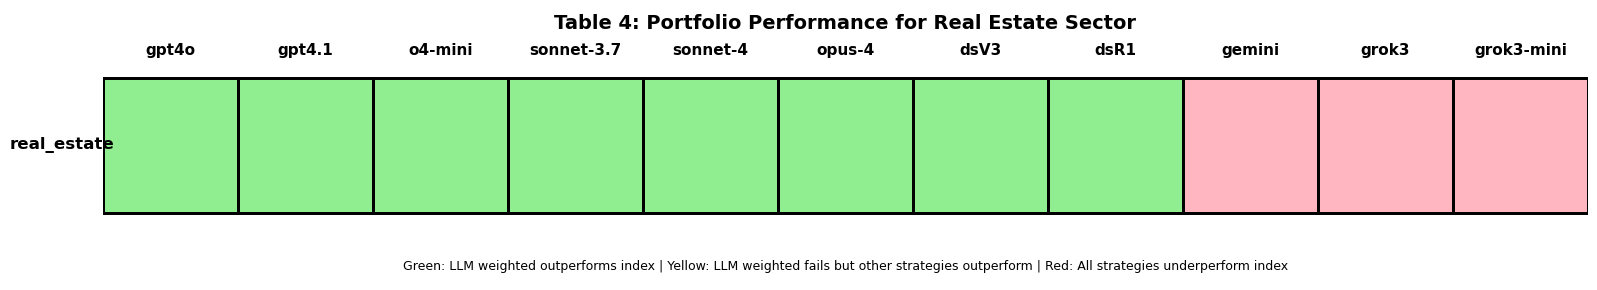

In [1047]:
import matplotlib.patches as patches

data = cumulative_returns_diff_comp.mean()


models = []
for idx in data.index:
    model = idx.split('_')[0] 
    if ' ' in model:  
        model = idx.split(' ')[0]
    if model not in models:
        models.append(model)

colors = []

for model in models:
    weighted_value = None
    other_values = []
    
    for idx, value in data.items():
        if idx.startswith(model):
            if 'weighted' in idx:
                weighted_value = value
            else:
                other_values.append(value)
    
    if weighted_value is not None and weighted_value < 0:
        colors.append('#90EE90')
    elif weighted_value is not None and any(v < 0 for v in other_values):
        colors.append('#FFD700') 
    else:
        colors.append('#FFB6C1')

fig, ax = plt.subplots(figsize=(len(models)*1.5, 3))
ax.set_xlim(0, len(models))
ax.set_ylim(0, 2)
ax.set_aspect('equal')

for j, (model, color) in enumerate(zip(models, colors)):
    
    rect = patches.Rectangle((j, 0.5), 1, 1, 
                           linewidth=2, edgecolor='black', facecolor=color)
    ax.add_patch(rect)

for j, model in enumerate(models):
    ax.text(j+0.5, 1.7, model, ha='center', va='center', 
            fontweight='bold', fontsize=11)

ax.text(-0.3, 1, sector_name, ha='center', va='center', 
        fontweight='bold', fontsize=12)

ax.axhline(y=0.5, xmin=0, xmax=1, color='black', linewidth=2)
ax.axhline(y=1.5, xmin=0, xmax=1, color='black', linewidth=2)
for j in range(len(models) + 1):
    ax.axvline(x=j, ymin=0.5/2, ymax=1.5/2, color='black', linewidth=2)

ax.text(len(models)/2, 1.9, f'Table 4: Portfolio Performance for {sector_name_full} Sector', 
        ha='center', va='center', fontweight='bold', fontsize=14)

legend_text = ('Green: LLM weighted outperforms index | '
               'Yellow: LLM weighted fails but other strategies outperform | '
               'Red: All strategies underperform index')
ax.text(len(models)/2, 0.1, legend_text, ha='center', va='center', fontsize=9)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.tight_layout()
plt.show()

## Summary metrics preparation

In [1048]:
sector_diff_summary = cumulative_returns_diff_comp.mean()

sector_results = pd.DataFrame({
    'sector': sector_name,
    'portfolio': sector_diff_summary.index,
    'difference': sector_diff_summary.values
})

csv_filename = 'difference/sector_performance_differences_stocks15_Jan.csv'

if os.path.exists(csv_filename):
    sector_results.to_csv(csv_filename, mode='a', header=False, index=False)
else:
    sector_results.to_csv(csv_filename, mode='w', header=True, index=False)

print(f"Data has been saved to {csv_filename}")
print(f"Current sector: {sector_name}")
print(f"Saved {len(sector_results)} indicators")

Data has been saved to difference/sector_performance_differences_stocks15_Jan.csv
Current sector: real_estate
Saved 55 indicators


## Volatilities

In [1049]:
for model_short in model_shorts:

    sector_mean = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}'].mean()
    sector_diff_sq = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}'].apply(lambda x: (x - sector_mean)**2)
    sector_sumdiff = sector_diff_sq.sum() / cumulative_returns_compare.size
    sector_volatility = round(sqrt(sector_sumdiff), 5)

    print(sector_name, sector_volatility, model_short)
    with open('metrics/portfolio_volatilities.csv', 'a', encoding='utf-8') as f:
        f.write(f'{model_short},{sector_name},{sector_volatility}\n')

real_estate 0.00369 gpt4o
real_estate 0.00376 gpt4.1
real_estate 0.00376 o4-mini
real_estate 0.00359 sonnet-3.7
real_estate 0.00395 sonnet-4
real_estate 0.00366 opus-4
real_estate 0.00384 dsV3
real_estate 0.00356 dsR1
real_estate 0.00343 gemini
real_estate 0.00389 grok3
real_estate 0.0039 grok3-mini


## Sector Index Volatility (not finished)

In [1050]:
# globals()[f'insample_stock_returns_{sector_name}'] = df_returns[globals()[f'stocks_{sector_name}']]
# temp_stock_return_insample = globals()[f'insample_stock_returns_{sector_name}']
# cumulative_returns_gpt_insample = pd.DataFrame(index=temp_stock_return_insample.index)
# cumulative_returns_gpt_insample

# i = 0
# for name, weight in weights.items():
#     temp_stock_return = globals()[f'insample_stock_returns_{sector_name}']
#     portfolio_return = (temp_stock_return * weight).sum(axis=1)
#     cumulative_returns_gpt_insample[name] = (1 + portfolio_return).cumprod()
#     i+=1

# print(cumulative_returns_gpt_insample.columns)

# cumulative_returns_gpt_insample[index_names[sector_ticker]] = (1 + index_data_ins[ticker]).cumprod()

# cumulative_returns_gpt_insample.index = pd.to_datetime(cumulative_returns_gpt_insample.index)
# insample_data = cumulative_returns_gpt_insample.loc[insample_startdate:insample_enddate]


# insample_data

In [1051]:
temp_index_data_ins = index_data_ins.copy()
insample_data = pd.DataFrame(index=temp_index_data_ins.index)
insample_data[index_names[sector_ticker]] = (1 + temp_index_data_ins[ticker]).cumprod()
insample_data.index = pd.to_datetime(insample_data.index)
insample_data

,SP500-60 real_estate
Date,
2020-01-13,1.024604
2020-01-20,1.034904
2020-01-27,1.015930
2020-02-03,1.033278
2020-02-10,1.083027
...,...
2024-12-02,1.136614
2024-12-09,1.108257
2024-12-16,1.053628


In [1052]:
insample_data.std()

SP500-60 real_estate    0.119908
dtype: float64

In [1053]:
temp_index_data_ins.std() # index volatility

^GSPC        0.027841
^IXIC        0.032153
^SP500-60    0.036862
dtype: float64

mean cumulative out-of-sample return for each sector:

In [1064]:
temp_index_data_outs = index_data_outs.copy()
outsample_data = pd.DataFrame(index=temp_index_data_outs.index)
outsample_data[index_names[sector_ticker]] = (1 + temp_index_data_outs[ticker]).cumprod()
outsample_data.index = pd.to_datetime(outsample_data.index)
outsample_data

,SP500-60 real_estate
Date,
2025-01-03,1.013428
2025-01-06,0.998331
2025-01-07,0.992134
2025-01-08,0.996067
2025-01-10,0.972349
...,...
2025-06-09,1.033491
2025-06-10,1.040602
2025-06-11,1.033848


In [1065]:
outsample_data.mean()

SP500-60 real_estate    1.022812
dtype: float64

## Portfolio Performance

Plot with Scrollable Legend (Display Only)

In [1054]:
temp_index_data_outs_compare = index_data_outs.copy()

temp_index_data_outs_compare.index = pd.to_datetime(temp_index_data_outs_compare.index)

index_first_date_compare = temp_index_data_outs_compare.index[0]
index_previous_trading_date_compare = index_first_date_compare - BDay(1)

index_baseline_row_compare = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs_compare.shape[1])),  
    index=[index_previous_trading_date_compare],                 
    columns=temp_index_data_outs_compare.columns               
)

temp_index_data_outs_compare_with_baseline = pd.concat([index_baseline_row_compare, temp_index_data_outs_compare])
# ##above is to add a baseline row with zeros to the index data outs compare dataframe##

index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_compare_with_baseline[ticker]).cumprod() ##

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)
outsample_data = cumulative_returns_compare.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for i, column in enumerate(outsample_data.columns):
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))

    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Jan 1 to Jun 15, 2025', 
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified",
    height=600
)

fig.update_layout(legend=dict(orientation = "v", yanchor="top",y=1,xanchor="left", x=1.02))

fig.show()

Plot with Multi-Column Legend (For Download/Export)

In [1055]:
temp_index_data_outs_compare = index_data_outs.copy()

temp_index_data_outs_compare.index = pd.to_datetime(temp_index_data_outs_compare.index)

index_first_date_compare = temp_index_data_outs_compare.index[0]
index_previous_trading_date_compare = index_first_date_compare - BDay(1)

index_baseline_row_compare = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs_compare.shape[1])),  
    index=[index_previous_trading_date_compare],                 
    columns=temp_index_data_outs_compare.columns               
)

temp_index_data_outs_compare_with_baseline = pd.concat([index_baseline_row_compare, temp_index_data_outs_compare])
# ##above is to add a baseline row with zeros to the index data outs compare dataframe##

index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_compare_with_baseline[ticker]).cumprod() ##

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)
outsample_data = cumulative_returns_compare.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for i, column in enumerate(outsample_data.columns):
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))

    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Jan 1 to Jun 15, 2025', 
    title_x = 0.5,
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified",
    width=1400,        
    height=800,
    margin=dict(b=150) 
)

# fig.update_layout(legend=dict(orientation = "v", yanchor="top",y=1,xanchor="left", x=1.02))
fig.update_layout(legend=dict(
        orientation="h", 
        yanchor="top",
        y=-0.15,  
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ))

fig.show()


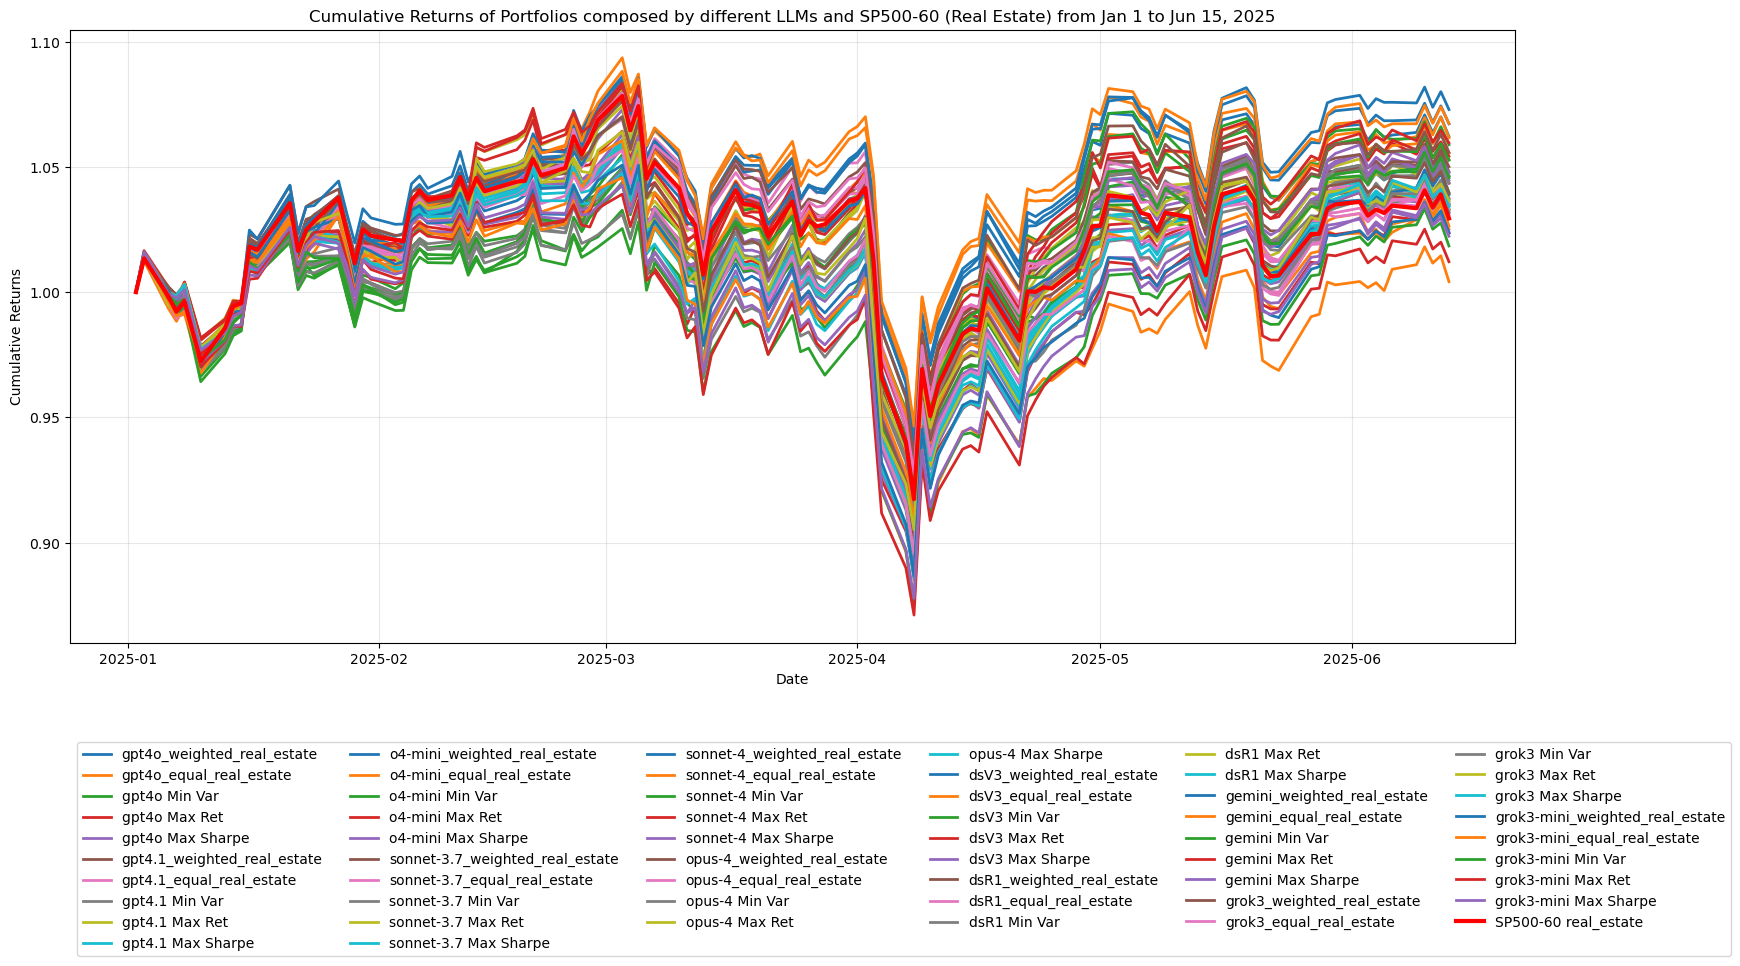

In [1056]:
fig, ax = plt.subplots(figsize=(18,10))

for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        ax.plot(outsample_data.index, outsample_data[column], 
               linewidth=3, color='red', label=column)
    else:
        ax.plot(outsample_data.index, outsample_data[column], 
               linewidth=2, label=column)

ax.set_title(f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Jan 1 to Jun 15, 2025')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax.legend(bbox_to_anchor=(0, -0.15), loc='upper left', ncol=6)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()